In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import linecache
import math
import tensorflow as tf
from tensorflow.python.framework import ops
import pickle

In [2]:
# initialize mode params
num_mode=3
ny=161
nz=23
y=np.zeros((ny,1))
z=np.zeros((nz,1))
data1=np.zeros((ny,nz))
data2=np.zeros((ny,nz))
mode_data=[['' for i in range(3)] for j in range(1)]

In [3]:
# get mode1-3 E and H data
j=0
for i in range(3+1,3+1+ny):
    y[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

j=0
for i in range(3+ny+2+1,3+ny+2+1+nz):
    z[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode1_ey.txt', i).split()
    j+=1

for k in range(num_mode):
    j=0
    for i in range(3+ny+2+nz+2+1,3+ny+2+nz+2+1+ny):
        data1[j,:]=linecache.getline(r'C:\Users\Ang Liu\Desktop\Mode_data\mode'+str(k+1)+'_ey.txt', i).split()
        j+=1  
    mode_data[0][k]=np.copy(data1.T)

# Normlize integral{|E|^2*dydz} to 1
dy=(y[-1,0]-y[0,0])/(y.shape[0]-1)
dz=(z[-1,0]-z[0,0])/(z.shape[0]-1)
norm_mode=np.zeros((1,num_mode))
for i in range(num_mode):
    norm_mode[0,i]=np.sum(mode_data[0][i]**2*dy*dz)
    mode_data[0][i]/=np.sqrt(norm_mode[0,i])

In [4]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[n_y,None])
    return X, Y

In [5]:
def initialize_parameters(parameters=None):
    if parameters==None:
        tf.set_random_seed(2)      
        W1 = tf.get_variable("W1", [25,19], initializer = tf.contrib.layers.xavier_initializer(seed = 3))
        b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
        W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 4))
        b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
        W3 = tf.get_variable("W3", [3,12], initializer = tf.contrib.layers.xavier_initializer(seed = 5))
        b3 = tf.get_variable("b3", [3,1], initializer = tf.zeros_initializer())
    else:
        W1 = tf.get_variable("W1",  initializer = tf.constant(parameters['W1']))
        b1 = tf.get_variable("b1",  initializer = tf.constant(parameters['b1']))
        W2 = tf.get_variable("W2",  initializer = tf.constant(parameters['W2']))
        b2 = tf.get_variable("b2",  initializer = tf.constant(parameters['b2']))
        W3 = tf.get_variable("W3",  initializer = tf.constant(parameters['W3']))
        b3 = tf.get_variable("b3",  initializer = tf.constant(parameters['b3']))
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [6]:
def forward_propagation(X, parameters):   
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1,X) + b1                                              # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.tanh(Z1)                                              # A1 = tanh(Z1)
    Z2 = tf.matmul(W2,A1) + b2                                              # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.tanh(Z2)                                              # A2 = tanh(Z2)
    Z3 = tf.matmul(W3,A2) + b3                                              # Z3 = np.dot(W3,Z2) + b3
   
    return Z3

In [7]:
def compute_cost2(Z3, Y):
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    Z3 = tf.transpose(Z3)
    Y = tf.transpose(Y)
    A3 = tf.nn.softmax(Z3)
    cost = tf.reduce_mean(tf.reduce_sum((Y-A3)**2,axis=1))
    
    return tf.transpose(A3),cost

In [8]:
def model_check(X_test, Y_test, parameters = None, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (n_x, _) = X_test.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_test.shape[0]                            # n_y : output size
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters(parameters)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    # cost1 = compute_cost1(Z3, Y) # L1 norm
    A3,cost2 = compute_cost2(Z3, Y) # L2 norm
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        [A3_test,cost2_test]=sess.run([A3, cost2], feed_dict={X: X_test, Y: Y_test})
    if print_cost==True:
        print("Test mean square error: {:.2e}.".format(cost2_test))
        
        
        return A3_test,cost2_test

In [9]:
f = open('parameters_min_cost_test.data', 'rb')
parameters,_,_ = pickle.load(f)
f.close()

In [10]:
num_data_set=100
m_all=100 # number of all the samples
pert=0.05 # perturbation of intensity after field's superposition
A3_test=np.zeros((num_data_set,3,m_all))
cost_test=np.zeros((num_data_set,1))
Y_test_set=np.zeros((num_data_set,3,m_all))
mode_comp_set=[''for i in range(num_data_set)]

In [11]:
for i_data_set in range(num_data_set):
    # Synthesis data set
    field_sp=[[0 for i in range(m_all)] for j in range(1)] # [[Ey(0),...,Ey(m_all-1)]]
    np.random.seed(None) # random seed(0)
    rd1=np.zeros((3,m_all))
    rd1[:,:]=np.random.rand(3,1)
    np.random.seed(None) # random seed(1)
    rd2=np.zeros((3,m_all))
    rd2[0:2,:]=np.random.rand(2,1)
    rd2[2,:]=np.random.rand(1,m_all)
    mode_comp=rd1*np.exp(1j*rd2*2*np.pi)
    mode_comp_set[i_data_set]=np.copy(mode_comp)
    mode_comp_label=rd1**2/np.sum(rd1**2,axis=0)
    for i in range(m_all):
        for j in range(num_mode):
            field_sp[0][i]+=mode_comp[j,i]*mode_data[0][j]
    
    # get farfield diffraction pattern
    sp_y=y.shape[0] # sampling points along y
    sp_z=z.shape[0] # sampling points along z
    ff_data=[]
    for i in range(m_all):
        ff_data.append(np.fft.fftshift(np.fft.fft2(field_sp[0][i]))/sp_y/sp_z)
    
    ff_i_data_x=['' for i in range(m_all)]
    for i in range(m_all):
        ff_i_data_x[i]=np.sum(np.abs(ff_data[i])**2,axis=0,keepdims=True)
        
    ff_i_data_x=np.array(ff_i_data_x).squeeze().T
    ff_i_data_x=ff_i_data_x[71:90,:]
    ff_i_data_x.shape
    
    X_test=np.log10(ff_i_data_x)
    Y_test=mode_comp_label
    Y_test_set[i_data_set,:,:]=Y_test
    [A3_test[i_data_set,:,:],cost_test[i_data_set,0]]=model_check(X_test, Y_test, parameters = parameters, print_cost = True)

Test mean square error: 2.28e-03.
Test mean square error: 1.44e-03.
Test mean square error: 2.68e-03.
Test mean square error: 1.75e-04.
Test mean square error: 1.85e-03.
Test mean square error: 1.03e-03.
Test mean square error: 9.49e-04.
Test mean square error: 3.37e-04.
Test mean square error: 3.03e-04.
Test mean square error: 2.13e-03.
Test mean square error: 1.69e-03.
Test mean square error: 2.93e-03.
Test mean square error: 6.32e-04.
Test mean square error: 9.08e-04.
Test mean square error: 1.25e-03.
Test mean square error: 5.26e-03.
Test mean square error: 3.14e-03.
Test mean square error: 8.97e-04.
Test mean square error: 5.12e-04.
Test mean square error: 7.28e-04.
Test mean square error: 2.64e-03.
Test mean square error: 6.45e-04.
Test mean square error: 5.96e-04.
Test mean square error: 3.89e-03.
Test mean square error: 1.69e-03.
Test mean square error: 1.47e-03.
Test mean square error: 1.61e-04.
Test mean square error: 3.67e-04.
Test mean square error: 1.53e-04.
Test mean squa

In [12]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/num_data_set)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

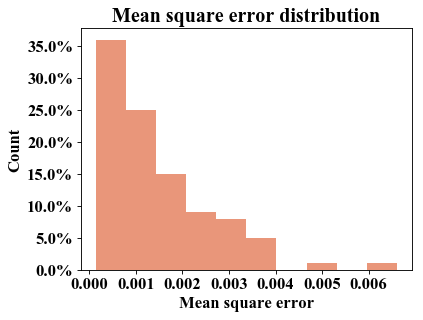

In [13]:
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}

plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
plt.title('Mean square error distribution', **font_suptitle)
plt.xlabel('Mean square error', **font_label)
plt.ylabel('Count', **font_label)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
plt.hist(cost_test,color='darksalmon')
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [ ]:
max_error_index=np.argsort(np.squeeze(cost_test))[-1:-11:-1]
print(max_error_index)
print(cost_test[max_error_index,0])

In [ ]:
dsi=3
si = 0
worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
sar=np.argsort(worst_dataset)[-1:-11:-1] # sorted array
print(sar)
plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 15}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 15}
plt.plot(np.sort(worst_dataset)[-30:][::-1],'o-')
plt.title('Worst 30 samples in worst MSE dataset',**font_suptitle,y=1.05)
plt.xlabel('Sample index',**font_label)
plt.ylabel('L2 norm',**font_label)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
plt.show()

np.random.seed(None)
print("index_{}:".format(sar[si]))
print(Y_test_set[max_error_index[dsi],:,:].T[sar[si],:],A3_test[max_error_index[dsi],:,:].T[sar[si],:])

In [ ]:
training_data_add=[]
dsi=0
si=0
yy,zz=np.meshgrid(y,z)
for dsi in range(10):
    for si in range(10):
        worst_dataset=np.sum(np.abs(A3_test[max_error_index[dsi],:,:]-Y_test_set[max_error_index[dsi],:,:])**2,axis=0)
        sar=np.argsort(worst_dataset)[-1:-11:-1] # sorted array
        if worst_dataset[sar[si]]>=5e-3:
            temp=mode_comp_set[max_error_index[dsi]][:,sar[si]]
            training_data_add.append(np.copy(temp))

            # Synthesis data set
            field_sp_inspect=np.zeros((23,161),dtype=np.complex)
            for i in range(num_mode):
                field_sp_inspect+=np.multiply(temp[i],mode_data[0][i])

            # view specified sample
            plt.figure(num=None, figsize=(8/1.5,6/1.5), dpi=80, facecolor='w', edgecolor='k')
            plt.title('Dataset_{}_sample_{}_|ey|'.format(max_error_index[dsi],sar[si]))
            plt.pcolormesh(yy,zz,np.abs(field_sp_inspect)/np.max(np.abs(field_sp_inspect)))
            plt.xlabel("Y direction/micron")
            plt.ylabel("Z direction/micron")
            plt.ylim(-0.11, 0.33)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.colorbar(orientation='horizontal')
            plt.show()
            print("Amplitude label: ")
            print(100*Y_test_set[max_error_index[dsi],:,sar[si]])
            print("Amplitude prediction: ")
            print(100*A3_test[max_error_index[dsi],:,sar[si]])
            print("Phase: ")      
            print(np.angle(temp,deg=True))


In [ ]:
# save training_data_add
f = open('training_data_add_2_102417.data', 'wb')
pickle.dump(training_data_add, f)
f.close()

In [ ]:
len(training_data_add)

In [ ]:
f = open('training_data_add_2_102417.data', 'rb')
data_la = pickle.load(f)
f.close()
len(data_la)

In [ ]:
import matplotlib
from numpy.random import randn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = '{:.4}'.format(100 * y/m_all)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

In [ ]:
plt.figure(num=None, figsize=(12,3), dpi=80, facecolor='w', edgecolor='k')

font_suptitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 18}
font_subtitle = {'family' : 'Times New Roman',
                 'weight' : 'bold',
                 'size'   : 15}
font_label = {'family' : 'Times New Roman',
              'weight' : 'bold',
              'size'   : 12}
font_tick = {'family' : 'Times New Roman',
             'weight' : 'semibold',
             'size'   : 12}

plt.suptitle('Absolute deviation distribution of worst MSE dataset',x=0.5,y=1.05,**font_suptitle)

plt.subplot(1,3,1)
plt.hist(np.abs(A3_test[max_error_index,0,:]-Y_test_set[max_error_index,0,:]),bins=12,range=(0,0.12))
plt.title('Mode 0',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,2)
plt.hist(np.abs(A3_test[max_error_index,1,:]-Y_test_set[max_error_index,1,:]),bins=12,range=(0,0.12))
plt.title('Mode 1',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.subplot(1,3,3)
plt.hist(np.abs(A3_test[max_error_index,2,:]-Y_test_set[max_error_index,2,:]),bins=12,range=(0,0.12))
plt.title('Mode 2',**font_subtitle)
plt.xlabel('Absolute deviation',**font_label)
plt.ylabel('Count',**font_label)
plt.xlim(-0.005,0.125)
plt.xticks(**font_tick)
plt.yticks(**font_tick)
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()